In [21]:
import polars as pl
import numpy as np
import torch
from torchvision.transforms import v2
from PIL import Image
import io
import matplotlib.pyplot as plt

from pathlib import Path
from rembg import remove, new_session
from ultralytics import SAM

DATA_PATH = Path.cwd().parent / "data"

In [22]:
session = new_session("sam")

100%|████████████████████████████████████████| 359M/359M [00:00<00:00, 656GB/s]
SHA256 hash of downloaded file: 62a29c39ebc8ae4dfc3d9ec8eae28c28efc8360233fa8ffba229eb9f6ac0c30a
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
100%|█████████████████████████████████████| 16.5M/16.5M [00:00<00:00, 28.2GB/s]
SHA256 hash of downloaded file: 9820a48a2d002aead7b4dab204d813176a810a5f1dc8f32e32f759cc070ae97e
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))

NVIDIA GeForce RTX 4060 Laptop GPU


In [3]:
# transforms = v2.Compose([
#     v2.ToImage(),  # Convert to tensor, only needed if you had a PIL image
#     v2.ToDtype(torch.uint8, scale=True),  # optional, most input are already uint8 at this point
#     v2.Resize(size=(224, 224), antialias=True),  # Or Resize(antialias=True)
#     v2.ToDtype(torch.float32, scale=True),  # Normalize expects float input
#     # v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])

In [13]:
data = pl.scan_parquet(DATA_PATH / "food101-validation.parquet")
test_data = data.head(10).collect()

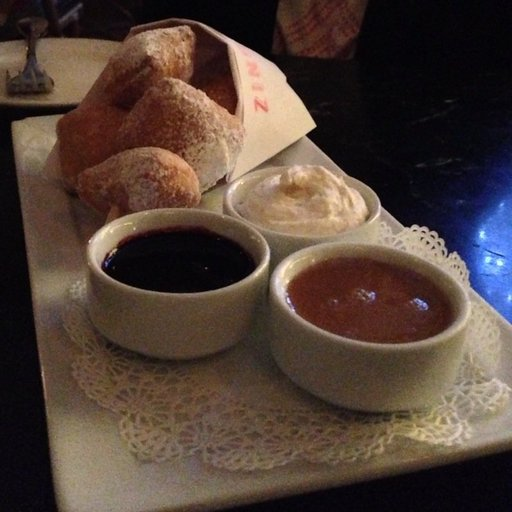

In [24]:
test = test_data[1]
image = Image.open(io.BytesIO(test['image'][0]['bytes']))
image

In [25]:
image.save(f"food_images/{test['label'][0]}.jpg")

In [26]:
# transformed = transforms(np.array(image)/255)

# transformed_image = v2.ToPILImage()(transformed)
# plt.imshow(transformed_image)

In [27]:
# from ultralytics.data.annotator import auto_annotate

# results = auto_annotate(data=Path("food_images"), det_model="yolo11x.pt", sam_model="sam2.1_b.pt")

# for result in results:
#     print(result.masks)

In [28]:
# from ultralytics import SAM

# # Load a model
# model = SAM("sam2.1_b.pt")

# # Display model information (optional)
# model.info()

# # Run inference
# results = model(source=[f"food_images/{test['label'][0]}.jpg"])

In [29]:
# for idx, result in enumerate(results):
#     print(result)
#     im_bgr = result.plot()
#     im_rgb = Image.fromarray(im_bgr[..., ::-1])
#     result.show()

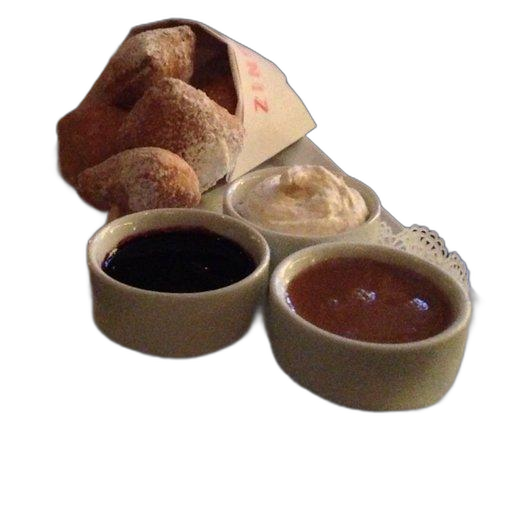

In [30]:
with open(f"food_images/{test['label'][0]}.jpg", "rb") as f:
    image = f.read()
image = remove(image, model=session)
# image.save(f"food_images/{test['label'][0]}_no_bg.jpg")

Image.open(io.BytesIO(image))